In [7]:
import os
import re
import numpy as np
import numpy.random as random
import pandas as pd
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from torch.autograd import Variable
import wandb
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision.datasets import ImageFolder
from PIL import Image

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
!pip install sentence-transformers
!pip install torchmetrics
!pip install torch-fidelity

In [9]:
# Data paths
train_annotations = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
train_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_annotations = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json'
val_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
test_images_dir = '/kaggle/input/coco-2017-dataset/coco2017/test2017'

Image ID: 000000532481
Number of captions: 5
Image URL: /kaggle/input/coco-2017-dataset/coco2017/val2017/000000532481.jpg


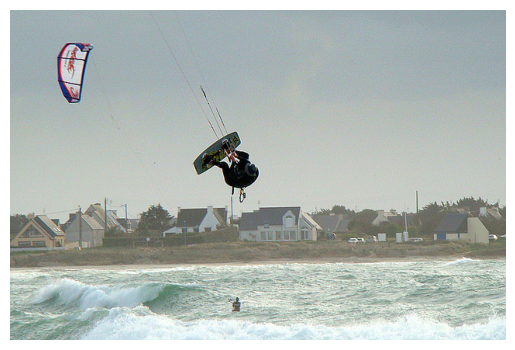

A person kitesurfing over the waves of the ocean's shore.
a kite surfer is doing a flying trick over some water
A man is flying up in the air and having fun. 
A guy is waterboarding in the ocean on a windy day.
A person kite boarding in rough seas near the shoreline.


In [10]:
def read_image_coco(image_id, image_dir):
    image_path = os.path.join(image_dir, f'{image_id:012d}.jpg')
    image = plt.imread(image_path)
    return image

def show_random_image_info(annotations_file, images_dir):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
        
    random_annotation = annotations['annotations'][np.random.randint(len(annotations['annotations']))]
    image_id = random_annotation['image_id']
    image = read_image_coco(image_id, images_dir)
    captions = [annotation['caption'] for annotation in annotations['annotations'] if annotation['image_id'] == image_id]
    formatted_id = f'{image_id:012d}'
    image_path = os.path.join(images_dir, formatted_id + '.jpg')

    print(f"Image ID: {formatted_id}")
    print(f"Number of captions: {len(captions)}")
    print(f"Image URL: {image_path}")

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    for caption in captions:
        print(caption)
       
    
show_random_image_info(val_annotations, val_images_dir)

In [11]:
print(f"Number of training images: {len(os.listdir(train_images_dir))}")
print(f"Number of validation images: {len(os.listdir(val_images_dir))}")
print(f"Number of test images: {len(os.listdir(test_images_dir))}")

Number of training images: 118287
Number of validation images: 5000
Number of test images: 40670


In [12]:
def calculate_caption_count_stats(train_annotations):
    with open(train_annotations, 'r') as f:
        annotations = json.load(f)

    image_caption_counts = {annotation['image_id']: 0 for annotation in annotations['annotations']}
    caption_lengths = []
    for annotation in annotations['annotations']:
        image_caption_counts[annotation['image_id']] += 1
        caption_lengths.append(len(annotation['caption']))

    caption_counts = list(image_caption_counts.values())
    caption_count_stats = {
        'mean': np.mean(caption_counts),
        'median': np.median(caption_counts),
        'min': np.min(caption_counts),
        'max': np.max(caption_counts),
        'avg_caption_length': np.mean(caption_lengths)
    }

    for stat, value in caption_count_stats.items():
        print(f"\t- {stat}: {value}")
        
print("Caption count per image statistics in training set:")
calculate_caption_count_stats(train_annotations)

print("\nCaption count per image statistics in validation set:")
calculate_caption_count_stats(val_annotations)

Caption count per image statistics in training set:
	- mean: 5.002688376575617
	- median: 5.0
	- min: 5
	- max: 7
	- avg_caption_length: 52.4888678215404

Caption count per image statistics in validation set:
	- mean: 5.0028
	- median: 5.0
	- min: 5
	- max: 7
	- avg_caption_length: 52.42028464060127


In [13]:

class CustomCocoDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None):
        if not os.path.exists(annotations_file):
            raise ValueError(f"File annotations không tồn tại: {annotations_file}")

        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)

        self.image_dir = image_dir
        self.transform = transform if transform else ToTensor()

    def __len__(self):
        return len(self.annotations['annotations'])

    def __getitem__(self, idx):
        image_id = self.annotations['annotations'][idx]['image_id']
        image_path = os.path.join(self.image_dir, f'{image_id:012d}.jpg')
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = self.annotations['annotations'][idx]['caption']
        caption = re.sub('[^A-Za-z0-9]+', ' ', caption)
        caption = caption.lower().strip()
        caption = caption.replace('.', '')
        return image, caption

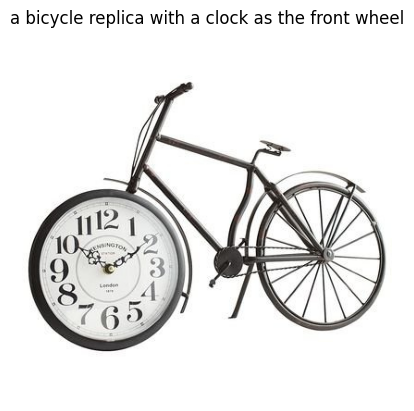

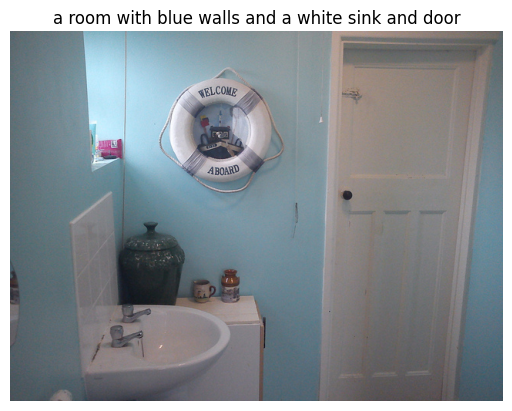

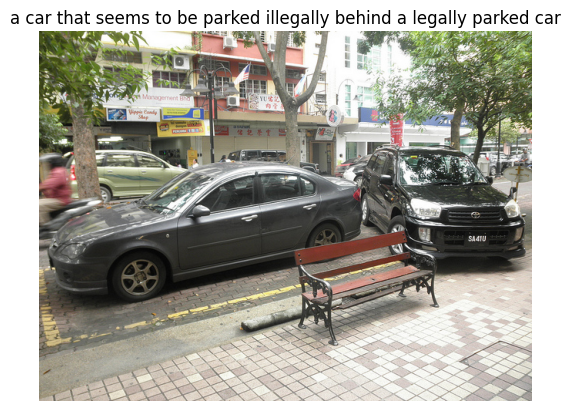

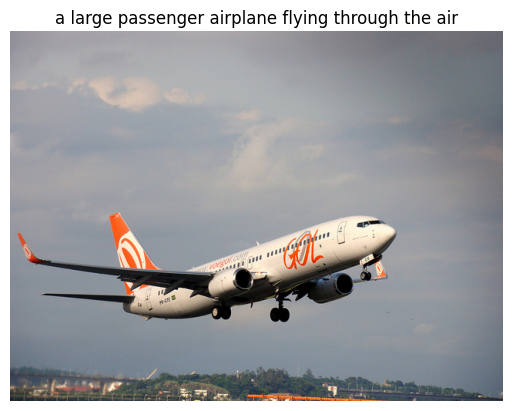

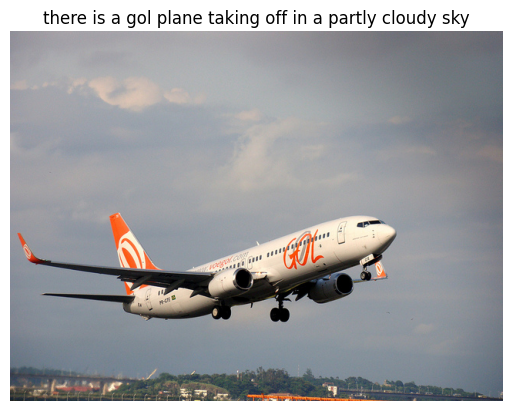

In [14]:
custom_coco_dataset = CustomCocoDataset(train_images_dir, train_annotations)

for i in range(5):
    image, caption = custom_coco_dataset[i]
    if image is None or caption is None:
        continue

    plt.imshow(image.permute(1, 2, 0))
    plt.title(caption)
    plt.axis('off')
    plt.show()    

In [15]:
def calculate_mean_std(dataset, device):
    mean_sum = torch.tensor([0.0, 0.0, 0.0], device=device)
    std_sum = torch.tensor([0.0, 0.0, 0.0], device=device)
    n_samples = 0

    for img_tensor, _ in tqdm(dataset, desc='Calculating mean and std'):
        img_tensor = img_tensor.to(device)
        mean_sum += img_tensor.mean([-1, -2])
        std_sum += img_tensor.std([-1, -2])
        n_samples += 1

    mean = mean_sum / n_samples
    std = std_sum / n_samples

    return mean.cpu(), std.cpu()

train_dataset = CustomCocoDataset(train_images_dir, train_annotations, transform=transforms.ToTensor())

In [16]:
from torch.utils.data import DataLoader
from torchvision import transforms

train_dataset = CustomCocoDataset(train_images_dir, train_annotations, transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4700, 0.4468, 0.4076], std=[0.2439, 0.2390, 0.2420])
]))

val_dataset = CustomCocoDataset(val_images_dir, val_annotations, transform=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.4700, 0.4468, 0.4076], std=[0.2439, 0.2390, 0.2420])
]))

def collate_fn(batch):
    images, captions = zip(*batch)
    return torch.stack(images), captions  # Stack images, keep captions as list

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=12, collate_fn=collate_fn)

In [17]:
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print("\n")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

Number of training batches: 36985
Number of validation batches: 1564


Number of training images: 591753
Number of validation images: 25014


In [18]:
images, captions = next(iter(train_dataloader))
print(f"Shape of images in a batch: {images.shape}")

Shape of images in a batch: torch.Size([16, 3, 256, 256])


In [19]:
def get_subset_dataloader(dataloader, subset_percent):
    num_samples = int(len(dataloader.dataset) * subset_percent)
    subset = Subset(dataloader.dataset, range(num_samples))
    subset_dataloader = DataLoader(subset, batch_size=dataloader.batch_size, collate_fn=dataloader.collate_fn)
    return subset_dataloader

# Get 10% of the original train and val DataLoaders
train_dataloader = get_subset_dataloader(train_dataloader, 0.001) # 1%
val_dataloader = get_subset_dataloader(val_dataloader, 0.001)

# Print the number of batches in the original and subset DataLoaders
print(f"Number of batches in the 10% subset train DataLoader: {len(train_dataloader)}")
print(f"Number of batches in the 10% subset val DataLoader: {len(val_dataloader)}")

Number of batches in the 10% subset train DataLoader: 37
Number of batches in the 10% subset val DataLoader: 2


In [20]:
print(f"Number of training images in 10% subset: {len(train_dataloader) * train_dataloader.batch_size}")
print(f"Number of validation images in 10% subset: {len(val_dataloader) * val_dataloader.batch_size}")

Number of training images in 10% subset: 592
Number of validation images in 10% subset: 32


In [21]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
text_emb_size = 384
img_size = 256

In [22]:
def encode_captions(captions):
    encoded_captions = sbert_model.encode(captions, show_progress_bar=False)
    return torch.tensor(encoded_captions, dtype=torch.float32)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('ConvTranspose') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
            
# SpectralNorm implementation
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = nn.Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = nn.Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = nn.Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [23]:
class Generator(nn.Module):
    def __init__(self, text_emb_size, img_size):
        super(Generator, self).__init__()
        self.fc = nn.Linear(text_emb_size, 512 * img_size // 16 * img_size // 16)
        self.main = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, text_emb):
        x = self.fc(text_emb)
        x = x.view(-1, 512, img_size // 16, img_size // 16)
        return self.main(x)

# Discriminator model
# Discriminator model
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_size, text_emb_size):
        super(Discriminator, self).__init__()
        self.img_branch = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.text_branch = nn.Sequential(
            nn.Linear(text_emb_size, 256),  # Kích thước kết quả cần điều chỉnh
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.joint_conv = nn.Sequential(
            SpectralNorm(nn.Conv2d(512, 512, 1, 1, 0, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(512, 1, 4, 1, 0, bias=False))
        )

    def forward(self, img, text_emb):
        img_feat = self.img_branch(img)
        text_feat = self.text_branch(text_emb)
        
        # Điều chỉnh text_feat để có đúng kích thước không gian phù hợp
        text_feat = text_feat.unsqueeze(2).unsqueeze(3)
        b, c, h, w = img_feat.size()
        text_feat = text_feat.expand(b, 256, h, w)
        joint_feat = torch.cat([img_feat, text_feat], dim=1)
        output = self.joint_conv(joint_feat).view(-1)
        return output
# GAN model
class GAN(nn.Module):
    def __init__(self, text_emb_size, img_size):
        super(GAN, self).__init__()
        self.generator = Generator(text_emb_size, img_size)
        self.discriminator = Discriminator(img_size, text_emb_size)

        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)

    def forward(self, text_emb, img_size):
        fake_images = self.generator(text_emb, img_size)
        return fake_images
    
gan = GAN(text_emb_size, img_size).to(device)

print(gan)

GAN(
  (generator): Generator(
    (fc): Linear(in_features=384, out_features=131072, bias=True)
    (main): Sequential(
      (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

In [24]:
lr_gen = 1e-4
lr_disc = 1e-4
# Khởi tạo optimizers
optim_gen = torch.optim.Adam(gan.generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
optim_disc = torch.optim.Adam(gan.discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.999))


# Số lượng epochs huấn luyện
num_epochs = 5

# Lưu trữ lịch sử loss cho việc plot
gen_train_losses = []
disc_train_losses = []
gen_val_losses = []
disc_val_losses = []

# Khởi tạo learning rates hiện tại
optim_gen_lr = lr_gen
optim_disc_lr = lr_disc

# Lưu trữ số lượng epochs mà loss không giảm
num_epochs_no_improve_gen = 0
num_epochs_no_improve_disc = 0

# Khởi tạo loss tốt nhất trên tập kiểm tra
best_gen_val_loss = float('inf')
best_disc_val_loss = float('inf')
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Khởi tạo schedulers
scheduler_gen = ReduceLROnPlateau(optim_gen, mode='min', factor=0.5, patience=10, verbose=True)
scheduler_disc = ReduceLROnPlateau(optim_disc, mode='min', factor=0.5, patience=10, verbose=True)

In [27]:
def gradient_penalty(discriminator, real_images, fake_images, text_embeddings):
    batch_size = real_images.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1).to(real_images.device)

    # Resize images to ensure they have the same dimensions
    interpolated_images = epsilon.view(-1, 1, 1, 1) * real_images.detach() + (1 - epsilon.view(-1, 1, 1, 1)) * fake_images.detach()
    interpolated_images = interpolated_images.requires_grad_(True)

    prob_interpolated = discriminator(interpolated_images, text_embeddings)

    gradients = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated_images,
        grad_outputs=torch.ones(prob_interpolated.size()).to(real_images.device),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradients_norm = gradients.norm(2, dim=1)
    gradient_pen = ((gradients_norm - 1) ** 2).mean()
    return gradient_pen

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from scipy import linalg
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from tqdm import tqdm

# Initialize FID và IS metrics
fid_metric = FrechetInceptionDistance(feature=2048).to(device)
is_metric = InceptionScore().to(device)

lambda_gp = 10  # hệ số điều chỉnh của gradient penalty, có thể thay đổi tuỳ thuộc vào mô hình và dữ liệu



# Hàm khởi tạo schedulers
def init_schedulers(optim_gen, optim_disc):
    scheduler_gen = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_gen, mode='min', factor=0.5, patience=5, verbose=True)
    scheduler_disc = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_disc, mode='min', factor=0.5, patience=5, verbose=True)
    return scheduler_gen, scheduler_disc

# Khởi tạo schedulers cùng optimizers sau khi đã khai báo optimizers
scheduler_gen, scheduler_disc = init_schedulers(optim_gen, optim_disc)

# Vòng lặp số epochs cho training
for epoch in range(num_epochs):
    # Training loop
    gen_train_loss = 0.0
    disc_train_loss = 0.0
    for batch_idx, (images, captions) in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        real_images = images.to(device)
        text_embeddings = encode_captions(captions).to(device) 

        # ===== Train Critic (Discriminator) =====
        optim_disc.zero_grad()

        for _ in range(5):  # số lần cập nhật Critic mỗi lần cập nhật Generator
            fake_images = gan.generator(text_embeddings)

            real_preds = gan.discriminator(real_images, text_embeddings)
            fake_preds = gan.discriminator(fake_images.detach(), text_embeddings)

            d_loss_real = real_preds.mean()
            d_loss_fake = fake_preds.mean()

            gradient_pen = gradient_penalty(gan.discriminator, real_images, fake_images, text_embeddings)

            disc_loss = -d_loss_real + d_loss_fake + lambda_gp * gradient_pen
            disc_train_loss += disc_loss.item()

            disc_loss.backward()
            optim_disc.step()

        # ===== Train Generator =====
        optim_gen.zero_grad()

        fake_images = gan.generator(text_embeddings)
        fake_preds = gan.discriminator(fake_images, text_embeddings)
        gen_loss = -fake_preds.mean()
        gen_train_loss += gen_loss.item()

        gen_loss.backward()
        optim_gen.step()

    # Tính toán mất mát trung bình cho training
    gen_train_loss /= len(train_dataloader)
    disc_train_loss /= len(train_dataloader)

    # Validation loop
    gen_val_loss = 0.0
    disc_val_loss = 0.0
    for val_batch_idx, (val_images, val_captions) in enumerate(tqdm(val_dataloader, desc='Validation')):
        val_real_images = val_images.to(device)
        val_text_embeddings = encode_captions(val_captions).to(device)

        # Đánh giá Critic
        val_fake_images = gan.generator(val_text_embeddings)
        val_real_preds = gan.discriminator(val_real_images, val_text_embeddings)
        val_fake_preds = gan.discriminator(val_fake_images.detach(), val_text_embeddings)

        val_disc_real_loss = val_real_preds.mean()
        val_disc_fake_loss = val_fake_preds.mean()

        val_gradient_pen = gradient_penalty(gan.discriminator, val_real_images, val_fake_images, val_text_embeddings)

        val_disc_loss = -val_disc_real_loss + val_disc_fake_loss + lambda_gp * val_gradient_pen
        disc_val_loss += val_disc_loss.item()

        # Đánh giá Generator
        val_fake_preds = gan.discriminator(val_fake_images, val_text_embeddings)
        val_gen_loss = -val_fake_preds.mean()
        gen_val_loss += val_gen_loss.item()

    # Tính toán mất mát trung bình cho validation
    disc_val_loss /= len(val_dataloader)
    gen_val_loss /= len(val_dataloader)

    # Lưu trữ các tổn thất
    gen_train_losses.append(gen_train_loss)
    disc_train_losses.append(disc_train_loss)
    gen_val_losses.append(gen_val_loss)
    disc_val_losses.append(disc_val_loss)

    # Tính toán chỉ số FID và IS
    real_images_for_fid = []
    fake_images_for_fid = []

    # Thu thập ảnh thật và giả cho việc tính FID
    for val_batch_idx, (val_images, val_captions) in enumerate(val_dataloader):
        val_real_images = val_images.to(device)
        val_text_embeddings = encode_captions(val_captions).to(device)
        val_fake_images = gan.generator(val_text_embeddings)

        real_images_for_fid.append(val_real_images)
        fake_images_for_fid.append(val_fake_images)

    # Kết hợp các tensor vào một tensor duy nhất
    real_images_for_fid = torch.cat(real_images_for_fid, dim=0)
    fake_images_for_fid = torch.cat(fake_images_for_fid, dim=0)

    # Compute FID
    real_images_for_fid = torch.clamp(real_images_for_fid, 0, 1)
    fake_images_for_fid = torch.clamp(fake_images_for_fid, 0, 1)
    real_images_for_fid = (real_images_for_fid * 255).to(torch.uint8)
    fake_images_for_fid = (fake_images_for_fid * 255).to(torch.uint8)
    fid_metric.update(real_images_for_fid, real=True)
    fid_metric.update(fake_images_for_fid, real=False)
    fid_score = fid_metric.compute()
    fid_metric.reset()

    # Compute IS
    is_metric.update(fake_images_for_fid)
    is_score, is_std = is_metric.compute()
    is_metric.reset()

    print(f'FID score: {fid_score:.4f}')
    print(f'Inception Score: {is_score:.4f} ± {is_std:.4f}')

    # In ra training và validation losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Discriminator Loss: {disc_train_loss:.4f}, Training Generator Loss: {gen_train_loss:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Discriminator Loss: {disc_val_loss:.4f}, Validation Generator Loss: {gen_val_loss:.4f}')
    
    # Tùy chọn: Log vào wandb (nếu bạn sử dụng wandb)
    # wandb.log({"gen_train_loss": gen_train_loss, 
    #            "disc_train_loss": disc_train_loss,
    #            "gen_val_loss": gen_val_loss,
    #            "disc_val_loss": disc_val_loss,
    #            "gen_lr": optim_gen.param_groups[0]['lr'],
    #            "disc_lr": optim_disc.param_groups[0]['lr'],
    #            "fid_score": fid_score,
    #            "inception_score": is_score})

    # Cập nhật learning rate schedulers nếu cần thiết
    scheduler_gen.step(gen_val_loss)
    scheduler_disc.step(disc_val_loss)

# Lưu mô hình cuối cùng
torch.save(gan.state_dict(), 'GAN_txt2img_model.pth')
wandb.finish()

Validation: 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


FID score: 414.9106
Inception Score: 1.0082 ± 0.0070
Epoch [1/5], Training Discriminator Loss: 1.3750, Training Generator Loss: -0.2489
Epoch [1/5], Validation Discriminator Loss: 0.1528, Validation Generator Loss: -0.3329


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


FID score: 407.7603
Inception Score: 1.0119 ± 0.0092
Epoch [2/5], Training Discriminator Loss: 1.0554, Training Generator Loss: -0.3335
Epoch [2/5], Validation Discriminator Loss: 0.1783, Validation Generator Loss: -0.2968


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


FID score: 384.0062
Inception Score: 1.0034 ± 0.0030
Epoch [3/5], Training Discriminator Loss: 0.9137, Training Generator Loss: -0.2893
Epoch [3/5], Validation Discriminator Loss: 0.1758, Validation Generator Loss: -0.2507


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


FID score: 367.4150
Inception Score: 1.0029 ± 0.0025
Epoch [4/5], Training Discriminator Loss: 0.6914, Training Generator Loss: -0.2244
Epoch [4/5], Validation Discriminator Loss: 0.2420, Validation Generator Loss: -0.2194


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


FID score: 383.6507
Inception Score: 1.0018 ± 0.0019
Epoch [5/5], Training Discriminator Loss: 0.7566, Training Generator Loss: -0.1977
Epoch [5/5], Validation Discriminator Loss: 0.1679, Validation Generator Loss: -0.1843


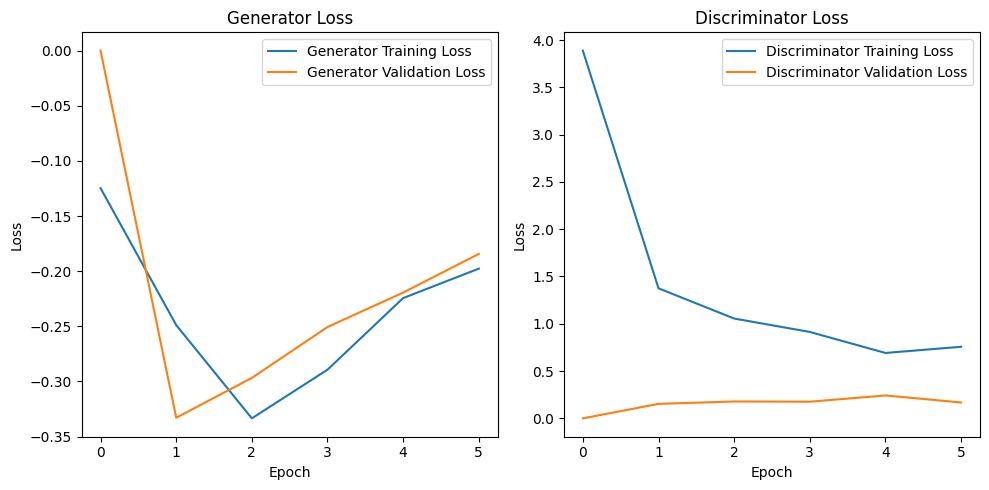

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(gen_train_losses, label='Generator Training Loss')
plt.plot(gen_val_losses, label='Generator Validation Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(disc_train_losses, label='Discriminator Training Loss')
plt.plot(disc_val_losses, label='Discriminator Validation Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

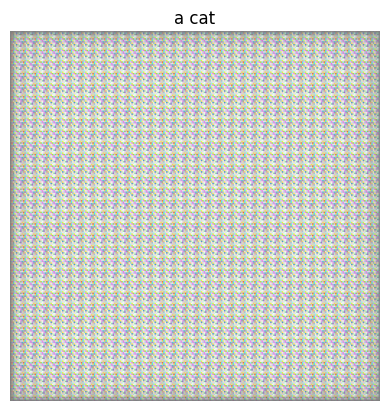

In [32]:
import torch
from torchvision.utils import save_image

# Khởi tạo mô hình GAN và load trọng số
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# gan = GAN(text_emb_size=384, img_size=224).to(device)
# gan.load_state_dict(torch.load('final_model.pth'))
gan.eval()  

sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def generate_image(caption):
    caption = re.sub('[^A-Za-z0-9]+', ' ', caption)
    caption = caption.lower().strip()
    caption = caption.replace('.', '')
    text_embedding = encode_captions([caption]).to(device)
    with torch.no_grad():
        generated_image = gan.generator(text_embedding)
        generated_image = (generated_image + 1) / 2  # Đưa giá trị về khoảng [0, 1]
    return generated_image

# Sinh ảnh từ caption
caption = "a cat"
generated_image = generate_image(caption)

plt.imshow(generated_image[0].cpu().permute(1, 2, 0))
plt.title(caption)
plt.axis('off')
plt.show()

# Lưu ảnh sinh ra
save_image(generated_image.cpu().data, '/kaggle/working/generated_image.png')